# CS339N Final Project - Head Motion as a Disease Biomarker

## Overview

This project explores the use of head motion, specifically framewise displacement, as a potential biomarker for disease. We focus on analyzing the framewise displacement derived from rsfMRI data to extract meaningful insights about patient movement during scans.

## fMRI Preprocessing

The raw fMRI BOLD signals undergo several preprocessing steps to ensure the data is clean and suitable for analysis. The major preprocessing steps include:
* Motion Correction: Aligns the fMRI images to correct for head movement during the scan.
* Slice Timing Correction: Adjusts for differences in acquisition time between slices.
* Spatial Normalization: Transforms the images to a standard space to allow for group analysis.
* Smoothing: Applies a Gaussian filter to reduce noise and improve signal-to-noise ratio.
* Confound Regression: Removes unwanted variability from the data, such as physiological noise and motion artifacts.
 
One of the key outputs of this preprocessing is the generation of timeseries "confounds," which include various metrics that describe the quality and characteristics of the fMRI data. Among these confounds is framewise displacement, a measure of head motion between consecutive frames.

## Data Layout

Here, I have extracted the framewise displacement data along with the metadata of each patient. This data is stored in the `framewise_displacement_data.npz` file. The extracted data is first loaded and converted into a dictionary format. This dictionary, `framewise_displacement_data`, is structured as follows:
* Keys: Each key is a combination of the subject ID and run ID, formatted as sub-<subject_id>_run-<run_id>.
* Values: Each value is a dictionary containing:
    * framewise_displacement: A list of framewise displacement values for the corresponding run. I believe the first element of each one is NaN--will fix this later and resave the file, though dropping the first element is a simple temporary fix.
    * dvars: spatial framewise standard deviation
    * rsmd: root mean square displacement between successive images
    * participant_info: A dictionary with metadata about the participant, including group, sex, and age.
 
## Relevant Prior Work

1. https://link.springer.com/article/10.1007/s10548-014-0358-6. Closest but older and small sample size with no biomarkers and averaged parameters
2. https://www.sciencedirect.com/science/article/pii/S2666956022000095#bib4
3. https://www.sciencedirect.com/science/article/pii/S1053811919310249
4. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.70143. Only large-scale attempt, but again the analyses are quite limited

In [ ]:
import numpy as np
import sys
sys.path.insert(1, '../src')

import data_processing as dp
import train_eval as te
import models_nn as mnn
import models_stats as mstats


In [20]:
from importlib import reload
reload(dp)
reload(te)
reload(mnn)
reload(mstats)


<module 'models_stats' from '/Users/kevin/Repos/head-motion-analysis/notebooks/../src/models_stats.py'>

PD: Removed 283 out of 603
Control: Removed 38 out of 82


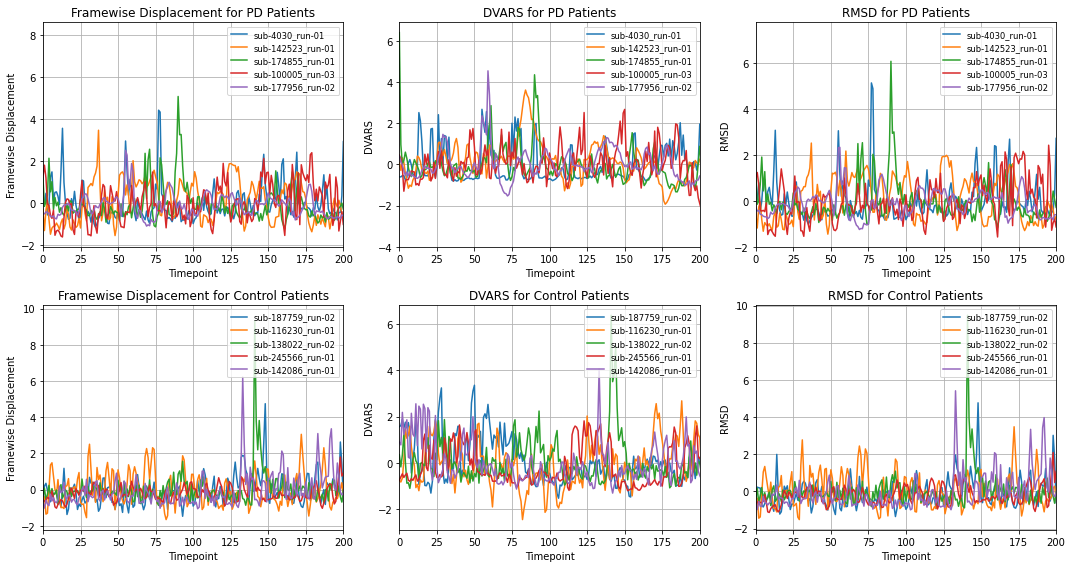

In [16]:
# Load the data from the .npz file
data_file = '../framewise_displacement_data.npz'
data = np.load(data_file, allow_pickle=True)

# Convert the loaded data to a dictionary
data_dict = {key: data[key].item() for key in data}

pd_keys = dp.filter_valid_subjects(data_dict, 'PD')
control_keys = dp.filter_valid_subjects(data_dict, 'Control')

# Plot the metrics
dp.plot_metrics(data_dict, pd_keys, control_keys)


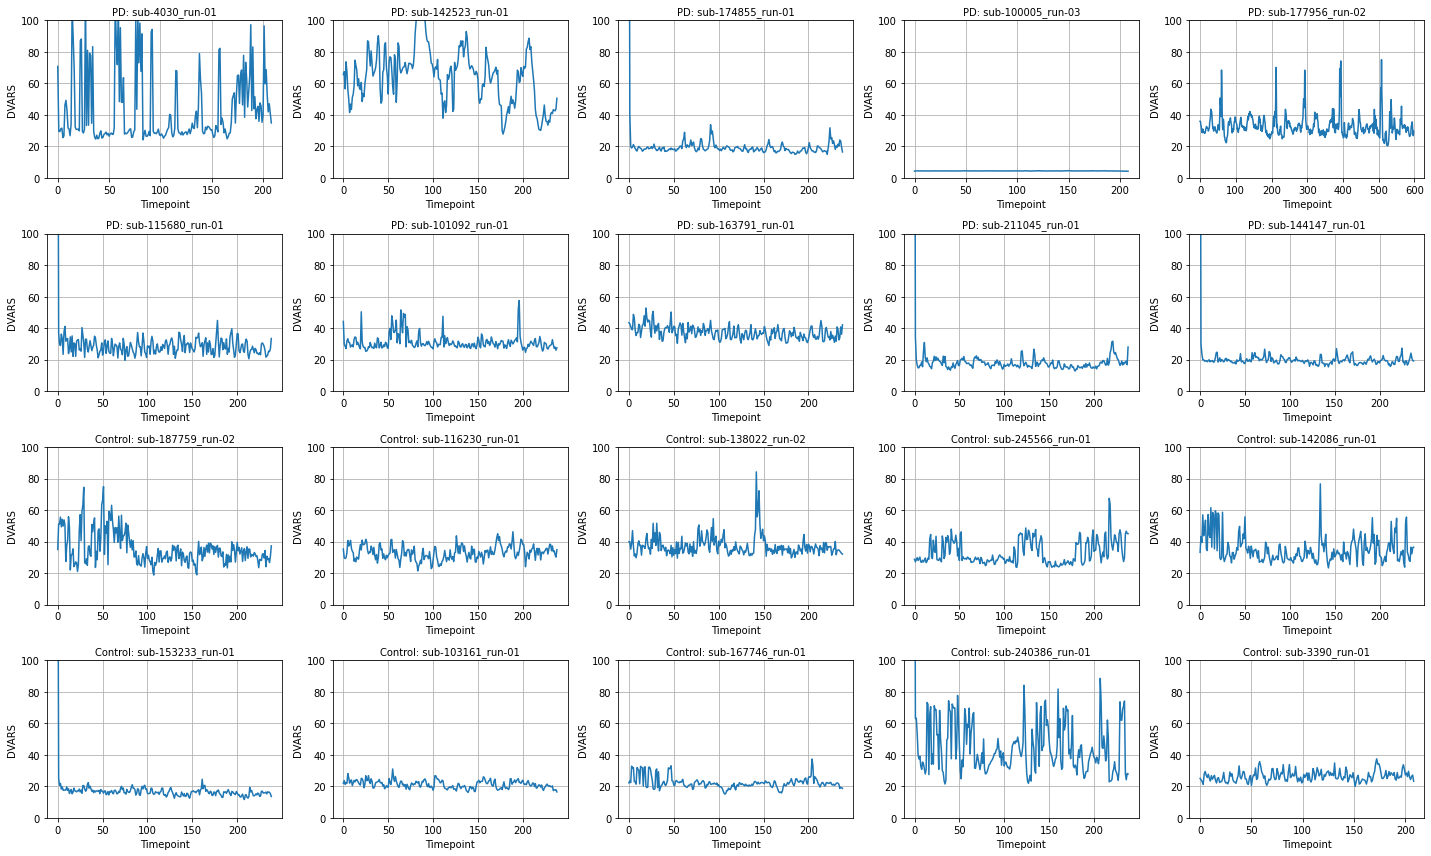

In [ ]:
# Plot the individual subplots for the metrics
dp.plot_individual_subplots(data_dict, pd_keys, control_keys, metric='dvars')


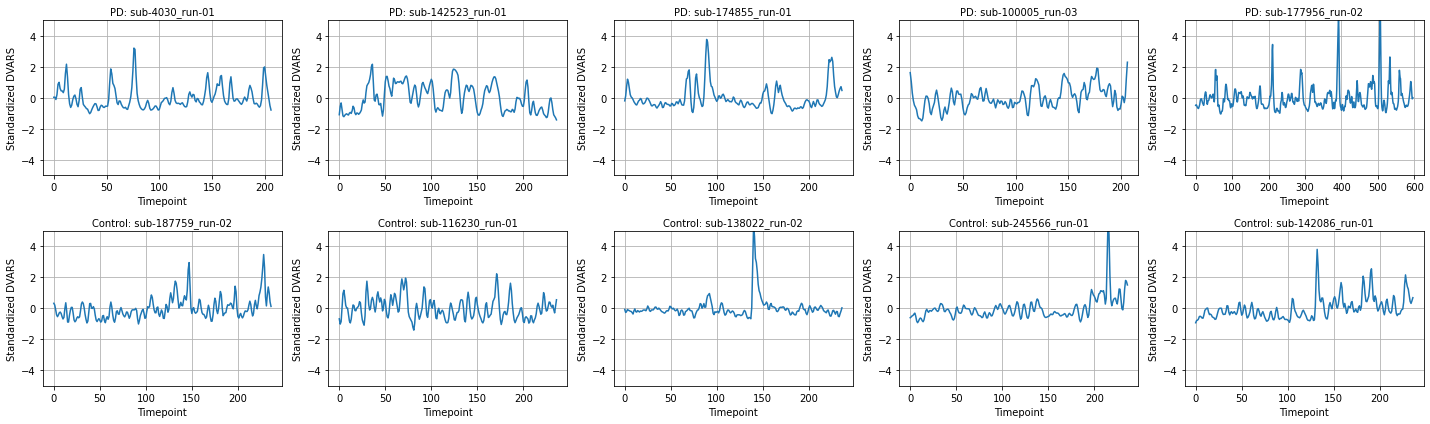

In [21]:
# Plot the standardized DVARS
dp.plot_standardized_dvars(data_dict, pd_keys, control_keys)


In [ ]:


import random
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------- Hyper-parameters ----------------------- #
MAX_LEN = 100  # truncate / zero-pad sequences to this length
BATCH_SIZE = 32
EPOCHS = 100
LR = 2e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG_SEED = 42

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

keys = pd_keys + control_keys
random.shuffle(keys)

dataset = dp.MotionDataset(data_dict, keys)
train_loader, val_loader = te.train_val_split(
        dataset, val_size=0.2, random_state=RNG_SEED, batch_size=BATCH_SIZE
)

models = {
    "GRU": mnn.RNNClassifier(cell="gru"),
    "LSTM": mnn.RNNClassifier(cell="lstm"),
    "Transformer": mnn.TransformerClassifier()
}

for name, model in models.items():
    print(f"\nTraining {name}…")
    te.train(
        model, train_loader, val_loader,
        device=DEVICE, epochs=EPOCHS, lr=LR,
    )
    acc, bal_acc, auc, _, _ = te.evaluate(model, val_loader, device=DEVICE)
    print(
        f"{name} final  ACC={acc:.3f}  BAL_ACC={bal_acc:.3f}  AUC={auc:.3f}"
    )

    preds, targets = te.get_predictions(model, val_loader, device=DEVICE)
    cm = confusion_matrix(targets, preds)
    print("Confusion matrix:\n", cm)
    print(classification_report(targets, preds, digits=3))



Training GRU…
Epoch 05/100  val_acc=0.556  val_bal_acc=0.641  val_auc=0.721
Epoch 10/100  val_acc=0.778  val_bal_acc=0.602  val_auc=0.686
Epoch 15/100  val_acc=0.708  val_bal_acc=0.508  val_auc=0.555
Epoch 20/100  val_acc=0.583  val_bal_acc=0.547  val_auc=0.527
Epoch 25/100  val_acc=0.778  val_bal_acc=0.602  val_auc=0.537
Epoch 30/100  val_acc=0.681  val_bal_acc=0.547  val_auc=0.564
Epoch 35/100  val_acc=0.722  val_bal_acc=0.461  val_auc=0.467
Epoch 40/100  val_acc=0.681  val_bal_acc=0.438  val_auc=0.436
Epoch 45/100  val_acc=0.736  val_bal_acc=0.469  val_auc=0.467
Epoch 50/100  val_acc=0.694  val_bal_acc=0.555  val_auc=0.574
Epoch 55/100  val_acc=0.722  val_bal_acc=0.570  val_auc=0.525
Epoch 60/100  val_acc=0.750  val_bal_acc=0.586  val_auc=0.504
Epoch 65/100  val_acc=0.708  val_bal_acc=0.508  val_auc=0.510
Epoch 70/100  val_acc=0.778  val_bal_acc=0.547  val_auc=0.559
Epoch 75/100  val_acc=0.778  val_bal_acc=0.547  val_auc=0.547
Epoch 80/100  val_acc=0.764  val_bal_acc=0.484  val_auc